# **CS210 - Term Project - Türker Yılmaz 31138**

## 1. **Stage: Scraping HTML datas and storing in a csv file**

In [1]:
#!pip install pytz

In [2]:
#pip install statsmodels
#!pip install plotly
#!pip install -U kaleido

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import pi
import seaborn as sns
import bs4
from bs4 import BeautifulSoup
import requests
import os
import datetime
from datetime import datetime, timedelta
import pytz
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import plotly.graph_objects as go
import kaleido
print("Succesfully imported needed libs")

Succesfully imported needed libs


### Scraping all files one by one

In [4]:
# Initialize a list to store the messages
messages_data = []

# Define the target sender's name
target_sender = "Türker Yılmaz"

In [5]:
# Function to process a single HTML file
def process_html_file(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)

    with open(file_path, 'r', encoding='utf-8') as html_file:
        soup = BeautifulSoup(html_file, 'html.parser')
        body = soup.find('body', class_='_5vb_ _2yq _a7o5')
        body2 = body.find('div', class_='clearfix _ikh')
        body3 = body2.find('div', class_='_4bl9')
        body4 = body3.find('div', class_='_li')
        upper_title = body4.find('div', class_='_a705')
        main_body = upper_title.find('div', class_='_a706')

        # Find all div elements containing messages
        message_divs = main_body.find_all('div', class_='pam _3-95 _2ph- _a6-g uiBoxWhite noborder')

        # Iterate through message divs
        for message_div in message_divs:
            # Extract sender's name
            sender_name = message_div.find('div', class_='_3-95 _2pim _a6-h _a6-i').text.strip()

            # Check if the sender is the target sender
            if sender_name == target_sender:
                
                # Extract timestamp and convert to datetime
                timestamp_str = message_div.find('div', class_='_3-94 _a6-o').text.strip()
                timestamp = datetime.strptime(timestamp_str, '%b %d, %Y, %I:%M %p')

                # Append the message data to the list
                messages_data.append({'sender': sender_name,'timestamp': timestamp})
        print(f"Processed file: {folder_path}")


In [6]:
# Function to process all HTML files in a folder
def process_html_folder(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.html'):
            process_html_file(folder_path, file_name)

# Function to log processed files
def log_processed_file(folder_name, file_name):
    with open('processed_log.txt', 'a') as log_file:
        log_file.write(f"{folder_name}/{file_name}\n")

# Check if a file has been processed
def is_file_processed(folder_name, file_name):
    with open('processed_log.txt', 'r') as log_file:
        return f"{folder_name}/{file_name}" in log_file.read().splitlines()

In [7]:
# Specify the main folder containing all the unique folders
main_folder_path = r'C:\Users\turke\jupyter\cs210 term project\html-datas'

# Process each unique folder
for unique_folder_name in os.listdir(main_folder_path):
    unique_folder_path = os.path.join(main_folder_path, unique_folder_name)

    # Check if the folder contains HTML files
    if os.path.isdir(unique_folder_path):
        process_html_folder(unique_folder_path)

Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\ahmetfurkanabaci_1093384765399616
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\ahmetsevkiozerli_940631847341576
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\aliosmankafali_987428195995274
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\alp_954828095921951
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\barismertbener_1132809684790457
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\batuhan_1498594253821896
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\berat_379680950168254
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\berkecan_377052664056296
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\canozcandai_967330108005083
Processed file: C:\Users\turke\jupyter\cs210 term project\html-datas\efecaganakkus_946335813437846
Processed file: C:\Users\turke

### Change time format to desired and derive section parameter from given message times

In [11]:
# Create a DataFrame
df = pd.DataFrame(messages_data)

# Additional Preprocessing Steps:

# Convert timestamp to the desired time zone (e.g., Turkey Standard Time, TRT)
#turkey_timezone = pytz.timezone('Europe/Istanbul')
#df['timestamp'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(turkey_timezone)
# Add eleven hours to the hour component
df['timestamp'] = df['timestamp'] + pd.to_timedelta('11:00:00')


# Filter data to exclude messages from 2022 and earlier
df = df[df['timestamp'].dt.year > 2022]

# Sort the DataFrame by timestamp
df.sort_values(by='timestamp', inplace=True)

# Calculate time differences between consecutive messages
df['time_diff'] = df['timestamp'].diff()

# Identify and mark sections based on a 7-minute gap
df['section'] = (df['time_diff'] > pd.Timedelta(minutes=7)).cumsum()

# If you want to keep only the relevant columns
df = df[['timestamp', 'sender', 'section']]

# Calculate section durations
section_durations = []
for section_id, section_df in df.groupby('section'):
    if len(section_df) == 1:
        # If there's only one message in the section, set section_duration to 2 minutes
        duration = timedelta(minutes=2)
    else:
        # Calculate the difference between the first and last message in the section
        duration = section_df['timestamp'].max() - section_df['timestamp'].min() + timedelta(minutes=2)

    # Append the result for each message in the section
    section_durations.extend([duration] * len(section_df))

# Add the calculated section durations to the DataFrame
df['section_duration'] = section_durations

# Save the DataFrame to a CSV file for further analysis or backup
df.to_csv('processed_data.csv', index=False)

# Display the DataFrame
print(df)


# Filter data for June to August
df_june_august = df[(df['timestamp'].dt.month > 6) & (df['timestamp'].dt.month <= 8)]

# Save the filtered data to a CSV file
df_june_august.to_csv('july_august_data.csv', index=False)

# Filter data for August to October
df_august_october = df[(df['timestamp'].dt.month > 8) & (df['timestamp'].dt.month <= 10)]

# Save the filtered data to a CSV file
df_august_october.to_csv('september_october_data.csv', index=False)

                timestamp         sender  section section_duration
14563 2023-01-01 01:51:00  Türker Yılmaz        0  0 days 00:03:00
14562 2023-01-01 01:51:00  Türker Yılmaz        0  0 days 00:03:00
2000  2023-01-01 01:52:00  Türker Yılmaz        0  0 days 00:03:00
1999  2023-01-01 04:31:00  Türker Yılmaz        1  0 days 00:02:00
1998  2023-01-01 10:47:00  Türker Yılmaz        2  0 days 00:05:00
...                   ...            ...      ...              ...
15083 2023-12-30 15:51:00  Türker Yılmaz     1891  0 days 00:04:00
2075  2023-12-30 17:19:00  Türker Yılmaz     1892  0 days 00:02:00
2076  2023-12-30 17:19:00  Türker Yılmaz     1892  0 days 00:02:00
16685 2023-12-30 18:48:00  Türker Yılmaz     1893  0 days 00:02:00
16686 2023-12-30 18:48:00  Türker Yılmaz     1893  0 days 00:02:00

[18226 rows x 4 columns]


## 2. **Stage: Using scraped data creating graphs EDA**
Important note!! as seasonal decomposition code alter the df, you have to move the above cell once before moving on scatter plot

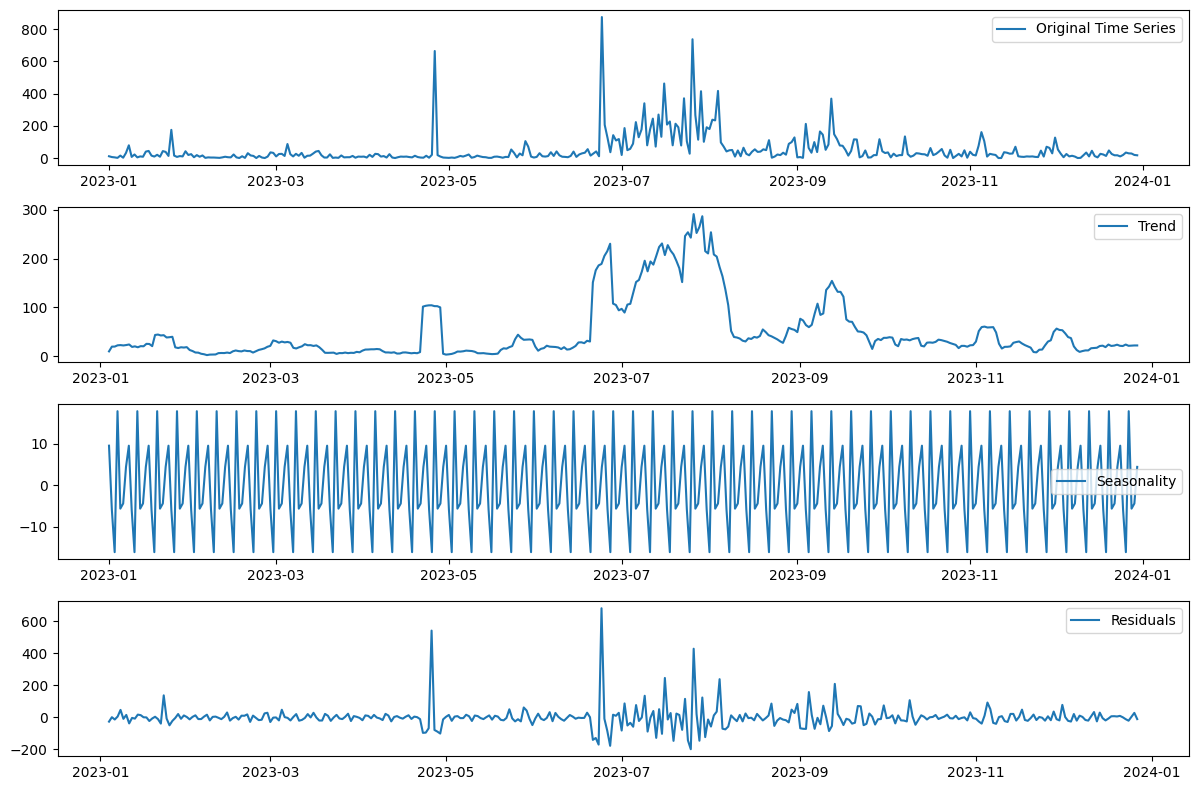

In [9]:

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample the data to a frequency (e.g., daily) and aggregate by count for seasonal analysis
df_resampled = df.resample('D').count()

# Perform seasonal decomposition
result = seasonal_decompose(df_resampled['sender'], model='additive', period=7)

# Plot the original time series, trend, seasonality, and residuals
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_resampled['sender'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()

# Save the plot as an image file (adjust the filename and format as needed)
plt.savefig('seasonal_decomposition_plot.pdf', dpi=300)  
plt.show()

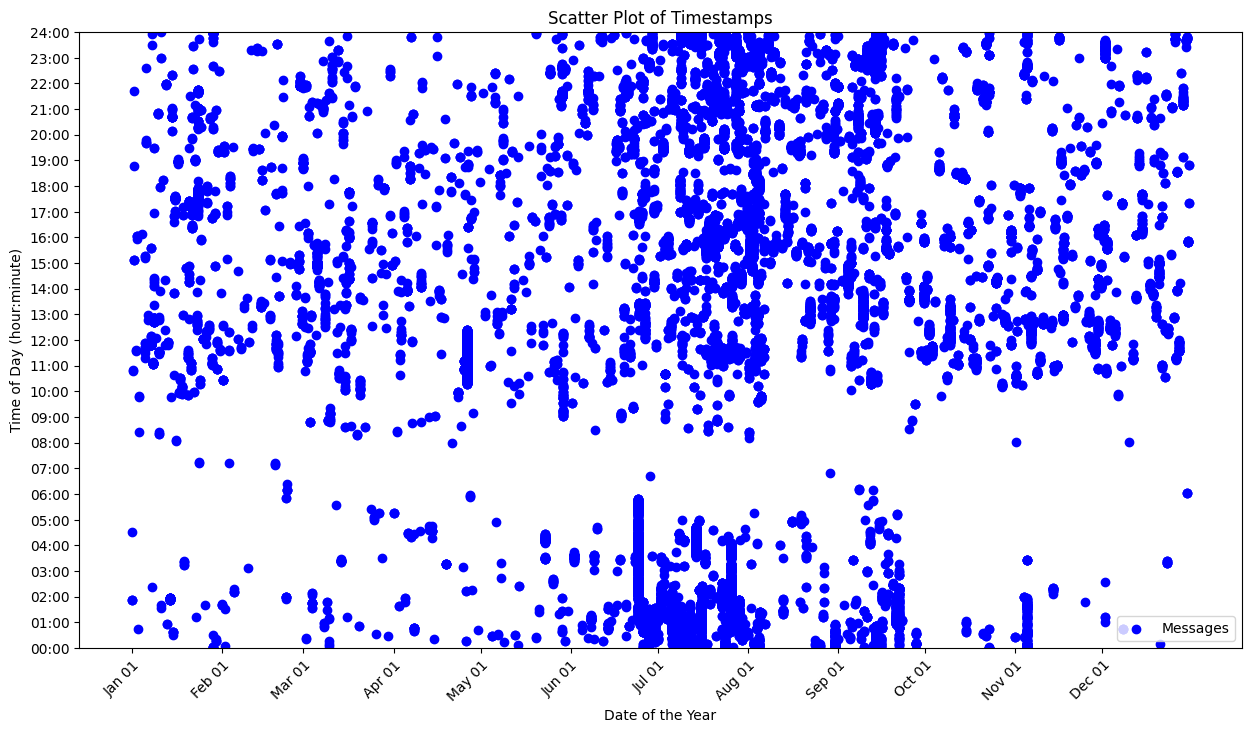

In [12]:
# Create a scatter plot
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(df['timestamp'], df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute, marker='o', color='blue', label='Messages')

# Manually set the x-axis ticks to display only the first day of each month
first_day_of_month_ticks = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='MS')
ax.set_xticks(first_day_of_month_ticks)

# Customize the x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Customize the y-axis (time of day in 10-minute intervals)
ax.yaxis.set_major_locator(plt.MultipleLocator(base=60))  # Show ticks every hour
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:02}:{:02}'.format(int(x) // 60, int(x) % 60)))

# Set y-axis limits to start from 0 and end at 24*60 (24 hours)
ax.set_ylim(0, 24 * 60)

# Rotate x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Customize the plot
plt.title('Scatter Plot of Timestamps')
plt.xlabel('Date of the Year')
plt.ylabel('Time of Day (hour:minute)')
plt.legend()

plt.savefig('scatter_plot.pdf', dpi=600) 
# Show the plot
plt.show()

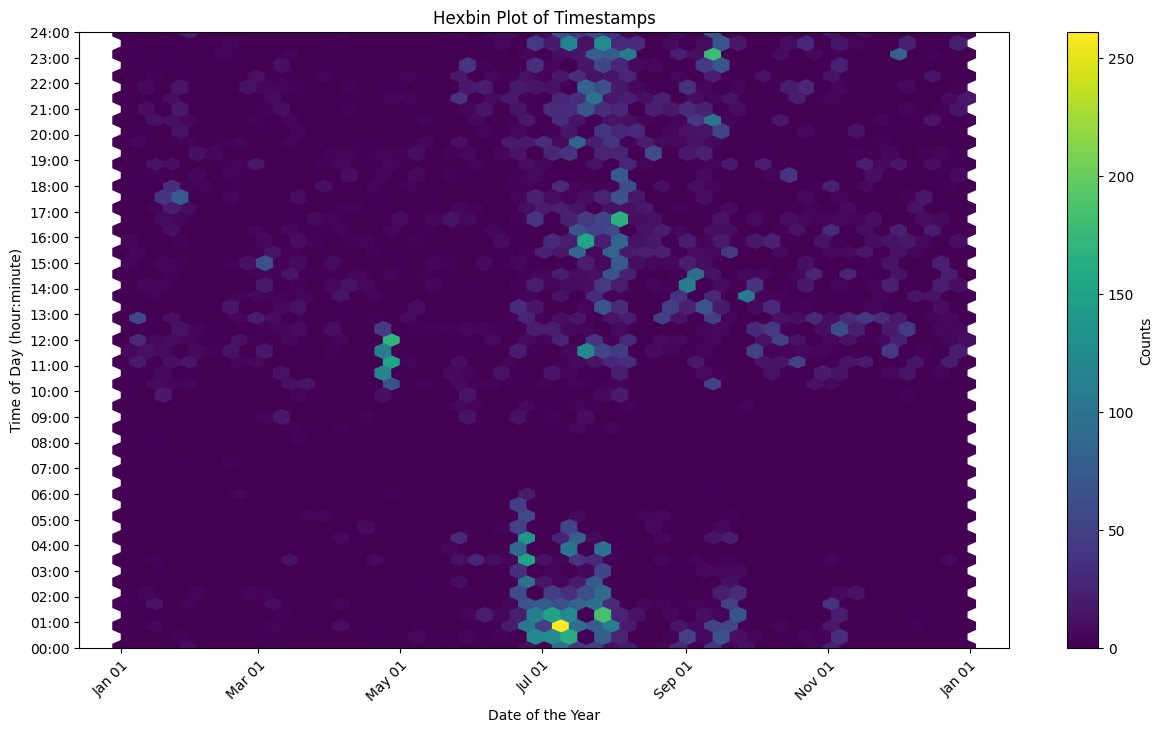

In [13]:
# Create a hexbin plot
fig, ax = plt.subplots(figsize=(15, 8))
hb = ax.hexbin(mdates.date2num(df['timestamp']), df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute, gridsize=50, cmap='viridis')

# Set the x-axis locator to AutoDateLocator
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Customize the x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Customize the y-axis (time of day in 10-minute intervals)
ax.yaxis.set_major_locator(plt.MultipleLocator(base=60))  # Show ticks every hour
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:02}:{:02}'.format(int(x) // 60, int(x) % 60)))

# Set y-axis limits to start from 0 and end at 24*60 (24 hours)
ax.set_ylim(0, 24 * 60)

# Add colorbar
cbar = plt.colorbar(hb, label='Counts')

# Rotate x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Customize the plot
plt.title('Hexbin Plot of Timestamps')
plt.xlabel('Date of the Year')
plt.ylabel('Time of Day (hour:minute)')

plt.savefig('hexbin_plot_1.pdf', dpi=600) 
# Show the plot
plt.show()

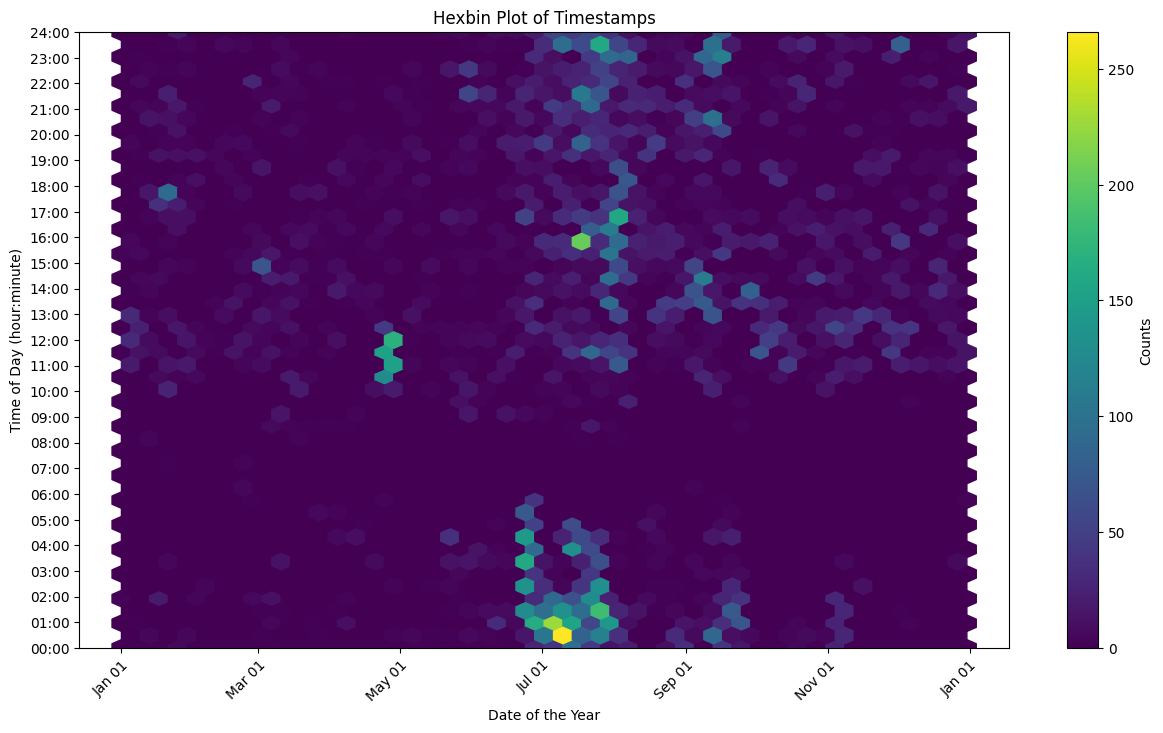

In [14]:
# Create a hexbin plot with increased gridsize
fig, ax = plt.subplots(figsize=(15, 8))
hb = ax.hexbin(mdates.date2num(df['timestamp']), df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute, gridsize=45, cmap='viridis')

# Set the x-axis locator to AutoDateLocator
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Customize the x-axis date format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Customize the y-axis (time of day in 10-minute intervals)
ax.yaxis.set_major_locator(plt.MultipleLocator(base=60))  # Show ticks every hour
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:02}:{:02}'.format(int(x) // 60, int(x) % 60)))

# Set y-axis limits to start from 0 and end at 24*60 (24 hours)
ax.set_ylim(0, 24 * 60)

# Add colorbar
cbar = plt.colorbar(hb, label='Counts')

# Rotate x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Customize the plot
plt.title('Hexbin Plot of Timestamps')
plt.xlabel('Date of the Year')
plt.ylabel('Time of Day (hour:minute)')

plt.savefig('hexbin_plot_2.pdf', dpi=600)
# Show the plot
plt.show()

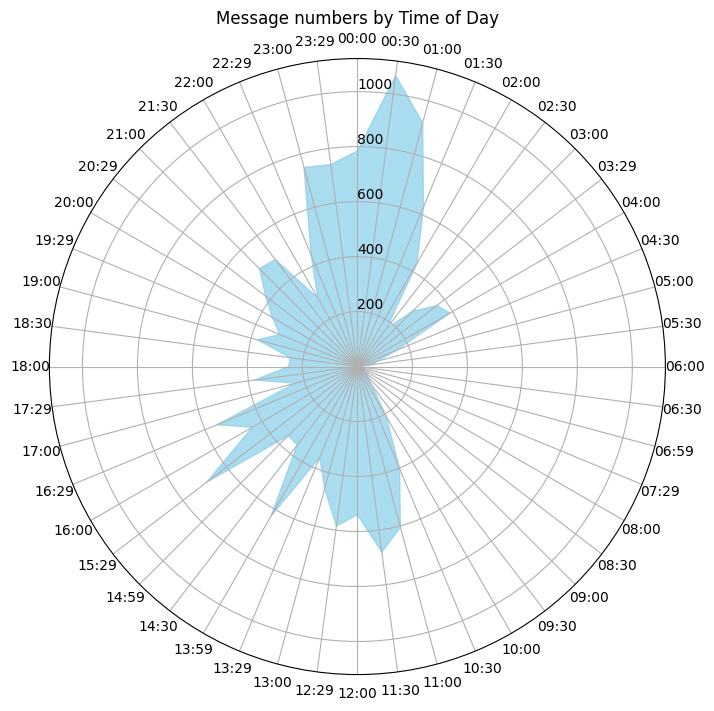

In [15]:
# Extract hour and minute components
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# Calculate the total minutes from midnight
df['total_minutes'] = df['hour'] * 60 + df['minute']

# Create bins for each 30 minutes
bins = np.arange(0, 24 * 60 + 1, 30)  # 30-minute intervals
df['time_bin'] = pd.cut(df['total_minutes'], bins=bins, labels=False)

# Group by time bins and calculate the number of messages in each bin
messages_by_time = df.groupby('time_bin')['sender'].count()

# Calculate the angles for polar plot
angles = np.linspace(0, 2 * np.pi, len(messages_by_time), endpoint=False)

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, messages_by_time, color='skyblue', alpha=0.7)

# Customize the plot
ax.set_theta_offset(np.pi / 2)  # Align the plot with 12 o'clock
ax.set_theta_direction(-1)  # Rotate clockwise
ax.set_rlabel_position(0)  # Move radial labels away from plotted line

# Set the x-axis ticks and labels
ax.set_xticks(angles)
ax.set_xticklabels([f'{int(angle / (2 * np.pi) * 24):02}:{int((angle / (2 * np.pi) * 24 * 60) % 60):02}' for angle in angles])

# Add title and show the plot
plt.title('Message numbers by Time of Day')
plt.savefig('circular_massagecount_1.pdf', dpi=600)
plt.show()

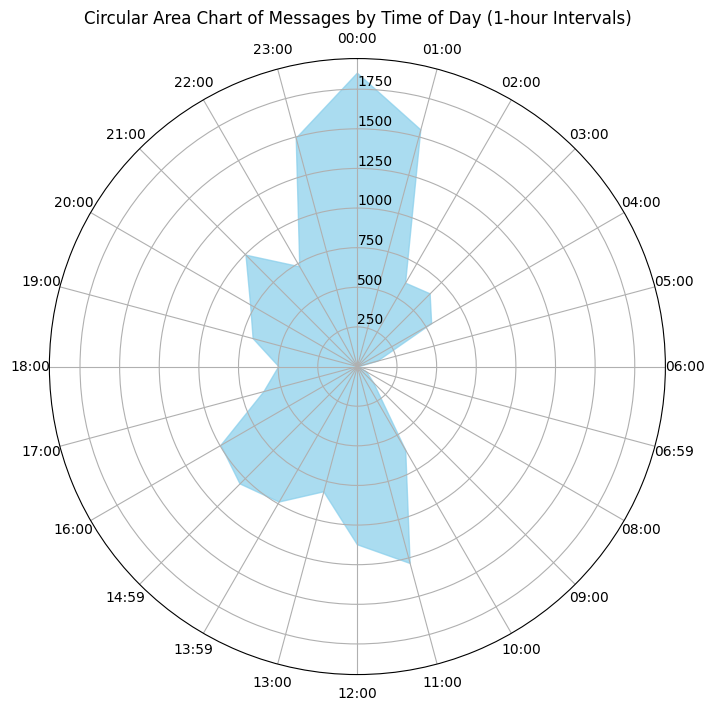

In [16]:
# Extract hour and minute components
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# Calculate the total minutes from midnight
df['total_minutes'] = df['hour'] * 60 + df['minute']

# Create bins for each 1 hour
bins = np.arange(0, 24 * 60 + 1, 60)  # 1-hour intervals
df['time_bin'] = pd.cut(df['total_minutes'], bins=bins, labels=False)

# Group by time bins and calculate the number of messages in each bin
messages_by_time = df.groupby('time_bin')['sender'].count()

# Calculate the angles for polar plot
angles = np.linspace(0, 2 * np.pi, len(messages_by_time), endpoint=False)

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, messages_by_time, color='skyblue', alpha=0.7)

# Customize the plot
ax.set_theta_offset(np.pi / 2)  # Align the plot with 12 o'clock
ax.set_theta_direction(-1)  # Rotate clockwise
ax.set_rlabel_position(0)  # Move radial labels away from plotted line

# Set the x-axis ticks and labels
ax.set_xticks(angles)
ax.set_xticklabels([f'{int(angle / (2 * np.pi) * 24):02}:{int((angle / (2 * np.pi) * 24 * 60) % 60):02}' for angle in angles])

# Add title and show the plot
plt.title('Circular Area Chart of Messages by Time of Day (1-hour Intervals)')
plt.show()

### Time spent distribution of all year

In [17]:
# Extract total minutes from midnight
df['total_minutes'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

# Create bins for each 30 minutes
bins, bin_edges = pd.cut(df['total_minutes'], bins=range(0, 24 * 60 + 30, 30), right=False, retbins=True)

# Convert bin_edges to bin_labels in the desired format
bin_labels = [f"{int(left // 60):02d}.{int(left % 60):02d}-{int(right // 60):02d}.{int(right % 60):02d}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

# Create a new DataFrame to store section information for each time interval
new_df = pd.DataFrame()

# Iterate over each section
for _, section_df in df.groupby('section'):
    section_start_time = section_df['timestamp'].min().time()
    section_end_time = (section_df['timestamp'].max() + pd.Timedelta(minutes=3)).time()

    # Calculate the time intervals within the section
    intervals = pd.cut(section_df['total_minutes'], bins=bin_edges, right=False)
    interval_counts = intervals.value_counts(sort=False)

    # Add information to the new DataFrame
    row_data = {
        'section_number': section_df['section'].iloc[0],
        'section_start_time': section_start_time,
        'section_end_time': section_end_time,
    }
    
    # Update the corresponding bins in the new DataFrame
    row_data.update({label: interval_counts.get(label, 0) for label in bin_labels})
    new_df = pd.concat([new_df, pd.DataFrame([row_data])], ignore_index=True)

# Fill NaN values with 0
new_df = new_df.fillna(0)
new_df = new_df.rename(columns={'23.30-24.00':'23.30-23.59'})
# Set the section_number as the index
new_df.set_index('section_number', inplace=True)

# Save the new DataFrame to a new database
new_df.to_csv('template_database.csv', index=False)


In [18]:

def process_data(df):
    # Extract total minutes from midnight
    if 'total_minutes' not in df.columns:
        df['total_minutes'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

    # Create bins for each 30 minutes
    bins, bin_edges = pd.cut(df['total_minutes'], bins=range(0, 24 * 60 + 30, 30), right=False, retbins=True)

    # Convert bin_edges to bin_labels in the desired format
    bin_labels = [f"{int(left // 60):02d}.{int(left % 60):02d}-{int(right // 60):02d}.{int(right % 60):02d}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

    # Create a new DataFrame to store section information for each time interval
    new_df = pd.DataFrame()

    # Iterate over each section
    for _, section_df in df.groupby('section'):
        section_start_time = section_df['timestamp'].min().time()
        section_end_time = (section_df['timestamp'].max() + pd.Timedelta(minutes=3)).time()

        # Calculate the time intervals within the section
        intervals = pd.cut(section_df['total_minutes'], bins=bin_edges, right=False)
        interval_counts = intervals.value_counts(sort=False)

        # Add information to the new DataFrame
        row_data = {
            'section_number': section_df['section'].iloc[0],
            'section_start_time': section_start_time,
            'section_end_time': section_end_time,
        }

        # Update the corresponding bins in the new DataFrame
        row_data.update({label: interval_counts.get(label, 0) for label in bin_labels})
        new_df = pd.concat([new_df, pd.DataFrame([row_data])], ignore_index=True)

    # Fill NaN values with 0
    new_df = new_df.fillna(0)
    new_df = new_df.rename(columns={'23.30-24.00': '23.30-23.59'})
    # Set the section_number as the index
    new_df.set_index('section_number', inplace=True)

    return new_df



# Process the data
processed_df = process_data(df)

# Save the new DataFrame to a new database
processed_df.to_csv('template_database.csv', index=False)

In [19]:

df = pd.read_csv('template_database.csv')

# Function to calculate the minutes between two time values
def calculate_minutes(start, end):
    start_dt = datetime.strptime(start, '%H.%M')
    end_dt = datetime.strptime(end, '%H.%M')
    duration = end_dt - start_dt
    return duration.total_seconds() / 60  # Convert seconds to minutes

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    start_time = row['section_start_time'].split(':')[0].zfill(2) + '.' + row['section_start_time'].split(':')[1]
    end_time = row['section_end_time'].split(':')[0].zfill(2) + '.' + row['section_end_time'].split(':')[1]

    # Iterate through the time bins
    for time_bin in df.columns[2:]:
        bin_start, bin_end = map(str.strip, time_bin.split('-'))

        # Check if the section overlaps with the current time bin
        overlap_start = max(bin_start, start_time)
        overlap_end = min(bin_end, end_time)

        if overlap_start <= overlap_end:
            # Calculate the duration in minutes for the section in the current time bin
            overlap_duration = calculate_minutes(overlap_start, overlap_end)

            # Update the corresponding cell with the calculated duration
            df.at[index, time_bin] = overlap_duration

# Save the updated DataFrame to a new CSV file
df.to_csv('filled_database.csv', index=False)

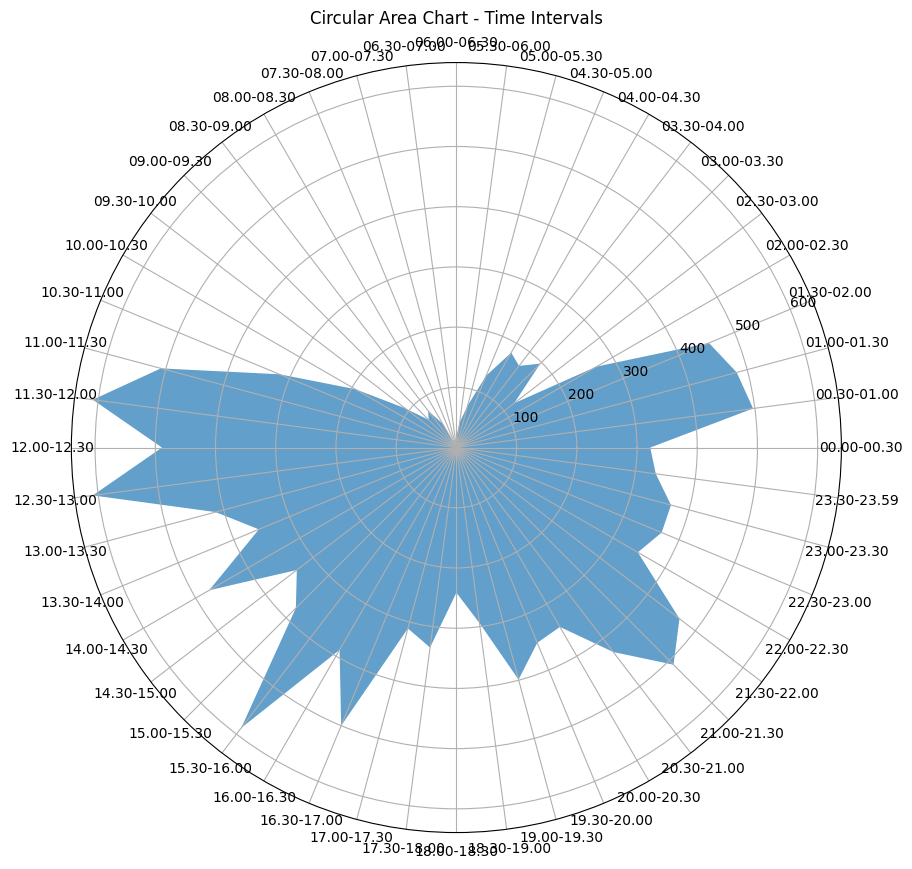

In [20]:
# Read the CSV file into a DataFrame
df = pd.read_csv('filled_database.csv')

# Create a new DataFrame without the time-related columns
df_data = df.iloc[:, 2:]

# Convert the DataFrame to a numpy array
data_array = df_data.to_numpy()

# Sum the values along each column
sums = np.sum(data_array, axis=0)

# Create a circular area chart
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(10, 10))

# Calculate angles for each interval
theta = np.linspace(0, 2*np.pi, len(sums), endpoint=False)

# Plot the circular area chart
ax.fill(theta, sums, alpha=0.7)

# Set the labels for each interval
interval_labels = df.columns[2:]
ax.set_xticks(theta)
ax.set_xticklabels(interval_labels)

# Set the title of the chart
ax.set_title('Circular Area Chart - Time Intervals', va='bottom')

# Display the circular area chart
plt.show()

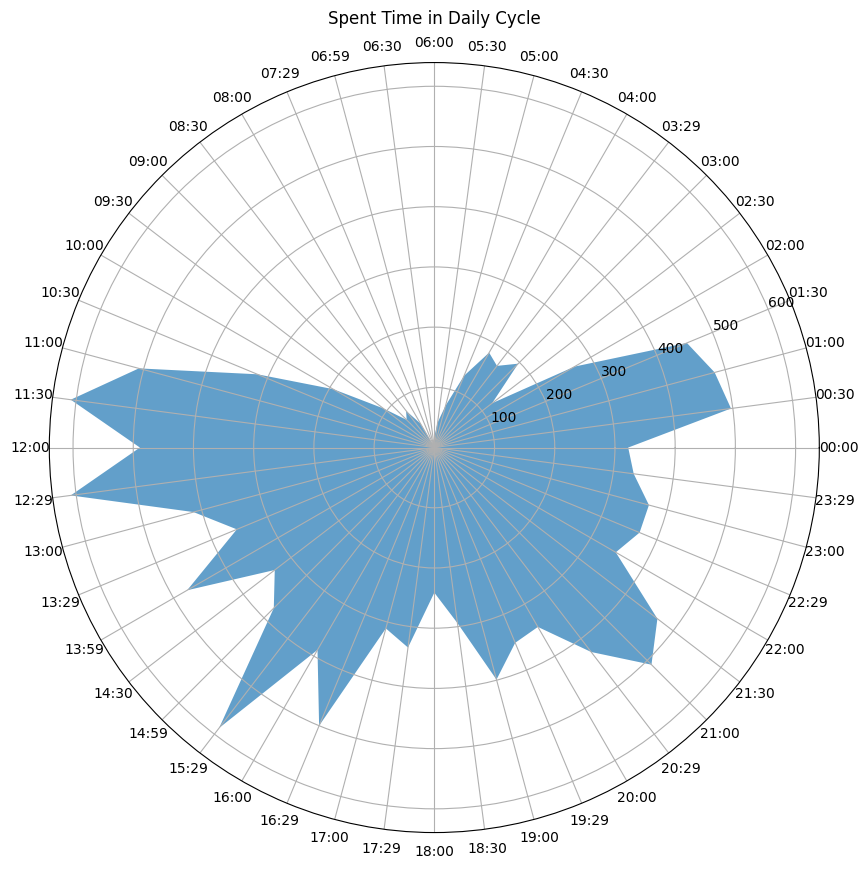

In [21]:
# Create a new DataFrame without the time-related columns
df_data = df.iloc[:, 2:]

# Convert the DataFrame to a numpy array
data_array = df_data.to_numpy()

# Sum the values along each column
sums = np.sum(data_array, axis=0)

# Create a circular area chart
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(10, 10))

# Calculate angles for each interval
theta = np.linspace(0, 2 * np.pi, len(sums), endpoint=False)

# Plot the circular area chart
ax.fill(theta, sums, alpha=0.7)

# Set the labels for each interval
interval_labels = [f'{int(angle / (2 * np.pi) * 24):02}:{int((angle / (2 * np.pi) * 24 * 60) % 60):02}' for angle in theta]
ax.set_xticks(theta)
ax.set_xticklabels(interval_labels)

# Set the title of the chart
ax.set_title('Spent Time in Daily Cycle', va='bottom')

plt.savefig('circular_time_spend.pdf', dpi=600) 
# Display the circular area chart
plt.show()

### Time spent distribution of July-August

In [22]:
df = pd.read_csv('july_august_data.csv')

# Convert 'timestamp' column to datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract total minutes from midnight
df['total_minutes'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

# Create bins for each 30 minutes
bins, bin_edges = pd.cut(df['total_minutes'], bins=range(0, 24 * 60 + 30, 30), right=False, retbins=True)

# Convert bin_edges to bin_labels in the desired format
bin_labels = [f"{int(left // 60):02d}.{int(left % 60):02d}-{int(right // 60):02d}.{int(right % 60):02d}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

# Create a new DataFrame to store section information for each time interval
new_df = pd.DataFrame()

# Iterate over each section
for _, section_df in df.groupby('section'):
    section_start_time = section_df['timestamp'].min().time()
    section_end_time = (section_df['timestamp'].max() + pd.Timedelta(minutes=3)).time()

    # Calculate the time intervals within the section
    intervals = pd.cut(section_df['total_minutes'], bins=bin_edges, right=False)
    interval_counts = intervals.value_counts(sort=False)

    # Add information to the new DataFrame
    row_data = {
        'section_number': section_df['section'].iloc[0],
        'section_start_time': section_start_time,
        'section_end_time': section_end_time,
    }
    
    # Update the corresponding bins in the new DataFrame
    row_data.update({label: interval_counts.get(label, 0) for label in bin_labels})
    new_df = pd.concat([new_df, pd.DataFrame([row_data])], ignore_index=True)

# Fill NaN values with 0
new_df = new_df.fillna(0)
new_df = new_df.rename(columns={'23.30-24.00':'23.30-23.59'})
# Set the section_number as the index
new_df.set_index('section_number', inplace=True)

# Save the new DataFrame to a new database
new_df.to_csv('template_database_july_august.csv', index=False)


In [23]:

df = pd.read_csv('template_database_july_august.csv')

# Function to calculate the minutes between two time values
def calculate_minutes(start, end):
    start_dt = datetime.strptime(start, '%H.%M')
    end_dt = datetime.strptime(end, '%H.%M')
    duration = end_dt - start_dt
    return duration.total_seconds() / 60  # Convert seconds to minutes

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    start_time = row['section_start_time'].split(':')[0].zfill(2) + '.' + row['section_start_time'].split(':')[1]
    end_time = row['section_end_time'].split(':')[0].zfill(2) + '.' + row['section_end_time'].split(':')[1]

    # Iterate through the time bins
    for time_bin in df.columns[2:]:
        bin_start, bin_end = map(str.strip, time_bin.split('-'))

        # Check if the section overlaps with the current time bin
        overlap_start = max(bin_start, start_time)
        overlap_end = min(bin_end, end_time)

        if overlap_start <= overlap_end:
            # Calculate the duration in minutes for the section in the current time bin
            overlap_duration = calculate_minutes(overlap_start, overlap_end)

            # Update the corresponding cell with the calculated duration
            df.at[index, time_bin] = overlap_duration

# Save the updated DataFrame to a new CSV file
df.to_csv('filled_database_july_august.csv', index=False)

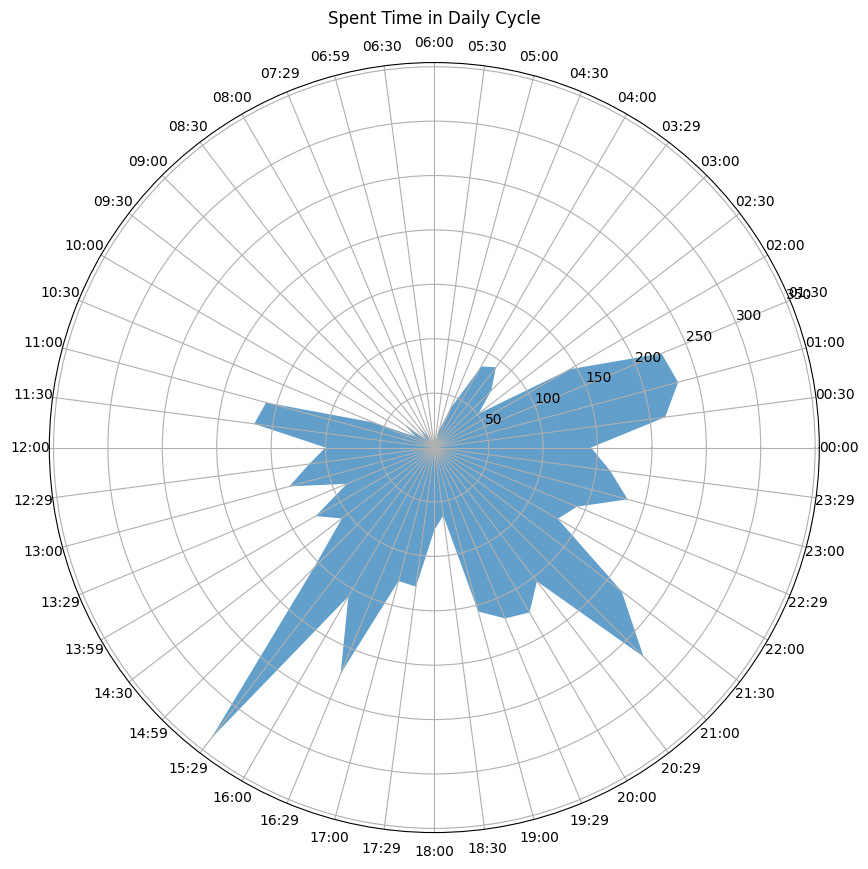

In [24]:
df = pd.read_csv('filled_database_july_august.csv')
# Create a new DataFrame without the time-related columns
df_data = df.iloc[:, 2:]

# Convert the DataFrame to a numpy array
data_array = df_data.to_numpy()

# Sum the values along each column
sums = np.sum(data_array, axis=0)

# Create a circular area chart
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(10, 10))

# Calculate angles for each interval
theta = np.linspace(0, 2 * np.pi, len(sums), endpoint=False)

# Plot the circular area chart
ax.fill(theta, sums, alpha=0.7)

# Set the labels for each interval
interval_labels = [f'{int(angle / (2 * np.pi) * 24):02}:{int((angle / (2 * np.pi) * 24 * 60) % 60):02}' for angle in theta]
ax.set_xticks(theta)
ax.set_xticklabels(interval_labels)

# Set the title of the chart
ax.set_title('Spent Time in Daily Cycle', va='bottom')

plt.savefig('circular_time_spen_before.pdf', dpi=600) 
# Display the circular area chart
plt.show()

### Time spent distribution of September-October

In [25]:
df = pd.read_csv('september_october_data.csv')

# Convert 'timestamp' column to datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract total minutes from midnight
df['total_minutes'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

# Create bins for each 30 minutes
bins, bin_edges = pd.cut(df['total_minutes'], bins=range(0, 24 * 60 + 30, 30), right=False, retbins=True)

# Convert bin_edges to bin_labels in the desired format
bin_labels = [f"{int(left // 60):02d}.{int(left % 60):02d}-{int(right // 60):02d}.{int(right % 60):02d}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

# Create a new DataFrame to store section information for each time interval
new_df = pd.DataFrame()

# Iterate over each section
for _, section_df in df.groupby('section'):
    section_start_time = section_df['timestamp'].min().time()
    section_end_time = (section_df['timestamp'].max() + pd.Timedelta(minutes=3)).time()

    # Calculate the time intervals within the section
    intervals = pd.cut(section_df['total_minutes'], bins=bin_edges, right=False)
    interval_counts = intervals.value_counts(sort=False)

    # Add information to the new DataFrame
    row_data = {
        'section_number': section_df['section'].iloc[0],
        'section_start_time': section_start_time,
        'section_end_time': section_end_time,
    }
    
    # Update the corresponding bins in the new DataFrame
    row_data.update({label: interval_counts.get(label, 0) for label in bin_labels})
    new_df = pd.concat([new_df, pd.DataFrame([row_data])], ignore_index=True)

# Fill NaN values with 0
new_df = new_df.fillna(0)
new_df = new_df.rename(columns={'23.30-24.00':'23.30-23.59'})
# Set the section_number as the index
new_df.set_index('section_number', inplace=True)

# Save the new DataFrame to a new database
new_df.to_csv('template_database_september_october.csv', index=False)

In [26]:

df = pd.read_csv('template_database_september_october.csv')

# Function to calculate the minutes between two time values
def calculate_minutes(start, end):
    start_dt = datetime.strptime(start, '%H.%M')
    end_dt = datetime.strptime(end, '%H.%M')
    duration = end_dt - start_dt
    return duration.total_seconds() / 60  # Convert seconds to minutes

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    start_time = row['section_start_time'].split(':')[0].zfill(2) + '.' + row['section_start_time'].split(':')[1]
    end_time = row['section_end_time'].split(':')[0].zfill(2) + '.' + row['section_end_time'].split(':')[1]

    # Iterate through the time bins
    for time_bin in df.columns[2:]:
        bin_start, bin_end = map(str.strip, time_bin.split('-'))

        # Check if the section overlaps with the current time bin
        overlap_start = max(bin_start, start_time)
        overlap_end = min(bin_end, end_time)

        if overlap_start <= overlap_end:
            # Calculate the duration in minutes for the section in the current time bin
            overlap_duration = calculate_minutes(overlap_start, overlap_end)

            # Update the corresponding cell with the calculated duration
            df.at[index, time_bin] = overlap_duration

# Save the updated DataFrame to a new CSV file
df.to_csv('filled_database_september_october.csv', index=False)

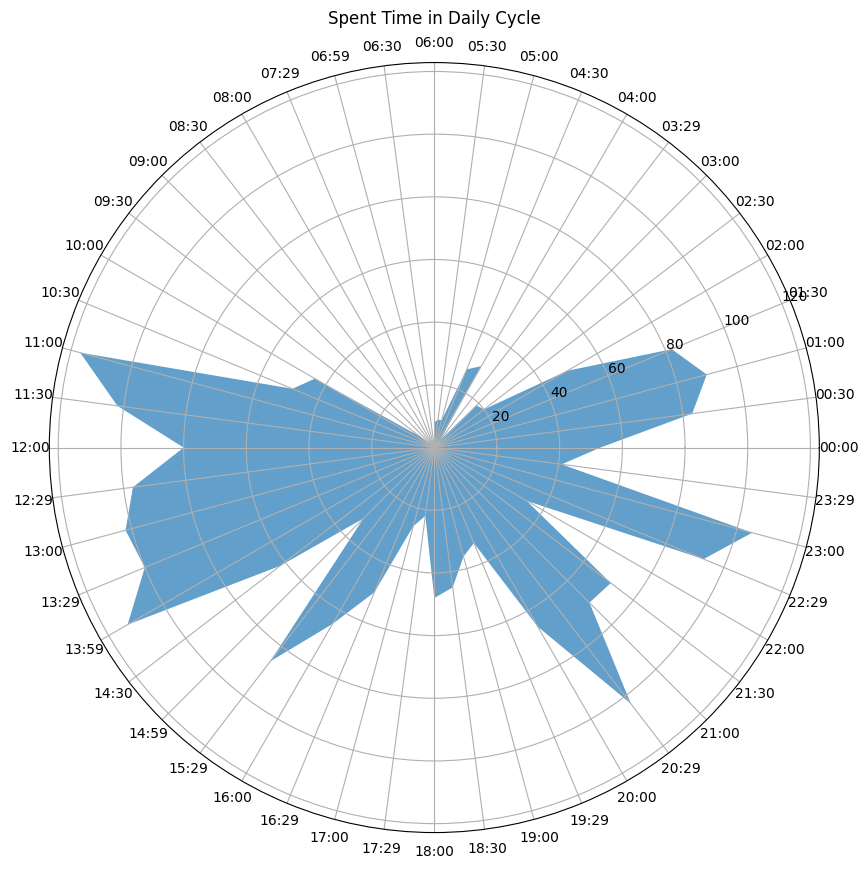

In [27]:
df = pd.read_csv('filled_database_september_october.csv')
# Create a new DataFrame without the time-related columns
df_data = df.iloc[:, 2:]

# Convert the DataFrame to a numpy array
data_array = df_data.to_numpy()

# Sum the values along each column
sums = np.sum(data_array, axis=0)

# Create a circular area chart
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(10, 10))

# Calculate angles for each interval
theta = np.linspace(0, 2 * np.pi, len(sums), endpoint=False)

# Plot the circular area chart
ax.fill(theta, sums, alpha=0.7)

# Set the labels for each interval
interval_labels = [f'{int(angle / (2 * np.pi) * 24):02}:{int((angle / (2 * np.pi) * 24 * 60) % 60):02}' for angle in theta]
ax.set_xticks(theta)
ax.set_xticklabels(interval_labels)

# Set the title of the chart
ax.set_title('Spent Time in Daily Cycle', va='bottom')

plt.savefig('circular_time_spend_after.pdf', dpi=600) 
# Display the circular area chart
plt.show()